In [12]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
import torchvision.datasets as dsets
from torchvision import transforms
import torch

from util import bfs, traverse_to_node, unpack_tree

In [4]:
def predict(clfs, x):
    preds = []
    for clf in clfs:
        preds.append(clf.predict(x)[0])
    return max(set(preds), key=preds.count)


def fit_ensemble(X, y, n_clfs=5):
    clfs = []
    for i in range(n_clfs):
        print(f'Training clf: {i}')
        ix = np.random.choice(range(X.shape[0]), X.shape[0] // 5)
        X_ = X[ix]
        y_ = y[ix]

        clf = DecisionTreeClassifier(random_state=i)
        model = clf.fit(X_, y_)

        clfs.append(clf)
    return clfs


def get_constraints(clf, sample, target_cls=0):
    root, feature, threshold = unpack_tree(clf)
    
    # Get the leaf node
    node, _ = traverse_to_node(root, sample, feature, threshold)

    # Get the shortest path from the leaf node to the target class's leaf node
    path = bfs(node, target_cls=target_cls)
    # Index of the top-most parent
    ix = path[::-1].index('parent')

    # Travel up to the top-most parent
    for dir in path[:-ix]:
        node = node.parent

    constraints = []
    # Don't change each feature in the remaining path,
    # add it to constraints
    for dir in path[-ix:]:
        thresh = threshold[node.id]
        feat = feature[node.id]

        if dir == 'left':
            constraints.append((f'f{feat}', '<=', thresh))
            node = node.left
        else:
            constraints.append((f'f{feat}', '>', thresh))
            node = node.right

    return constraints

In [5]:
np.random.seed(0)

# Prepare the data
num_classes = 10

train_data = dsets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
test_data = dsets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download=True)

X, y = [], []
X_test, y_test = [], []

for row in train_data:
    X.append(row[0])
    y.append(row[1])

for row in test_data:
    X_test.append(row[0])
    y_test.append(row[1])

X = torch.vstack(X)
X = X.reshape(X.shape[0], -1).numpy()
y = np.array(y)
X_test = torch.vstack(X_test)
X_test = X_test.reshape(X_test.shape[0], -1).numpy()
y_test = np.array(y_test)

clfs = fit_ensemble(X, y, n_clfs=100)

Training clf: 0
Training clf: 1
Training clf: 2
Training clf: 3
Training clf: 4
Training clf: 5
Training clf: 6
Training clf: 7
Training clf: 8
Training clf: 9
Training clf: 10
Training clf: 11
Training clf: 12
Training clf: 13
Training clf: 14
Training clf: 15
Training clf: 16
Training clf: 17
Training clf: 18
Training clf: 19
Training clf: 20
Training clf: 21
Training clf: 22
Training clf: 23
Training clf: 24
Training clf: 25
Training clf: 26
Training clf: 27
Training clf: 28
Training clf: 29
Training clf: 30
Training clf: 31
Training clf: 32
Training clf: 33
Training clf: 34
Training clf: 35
Training clf: 36
Training clf: 37
Training clf: 38
Training clf: 39
Training clf: 40
Training clf: 41
Training clf: 42
Training clf: 43
Training clf: 44
Training clf: 45
Training clf: 46
Training clf: 47
Training clf: 48
Training clf: 49
Training clf: 50
Training clf: 51
Training clf: 52
Training clf: 53
Training clf: 54
Training clf: 55
Training clf: 56
Training clf: 57
Training clf: 58
Trainin

In [18]:
sample = X[1]
constraints = []
target_cls = 1

for clf in clfs:
    root, feature, threshold = unpack_tree(clf)
    actual_label = clf.predict([sample])[0]

    if actual_label == target_cls:
        continue
    constraints_ = get_constraints(
        clf,
        sample,
        target_cls=target_cls
    )

    constraints.append(constraints_)

for i, constraint in enumerate(constraints[:5]):
    print(f"Classifier {i}: {constraint}")

Classifier 0: [('f408', '>', 0.019607843831181526), ('f386', '<=', 0.02549019642174244), ('f378', '>', 0.029411765281111002), ('f323', '>', 0.9117647111415863), ('f263', '<=', 0.18627451360225677), ('f435', '>', 0.9901960790157318)]
Classifier 1: [('f434', '>', 0.013725490774959326), ('f375', '<=', 0.0019607844296842813), ('f550', '<=', 0.0058823530562222), ('f234', '>', 0.007843137718737125), ('f548', '>', 0.6745098233222961), ('f543', '<=', 0.0117647061124444), ('f661', '>', 0.35098040103912354)]
Classifier 2: [('f483', '<=', 0.2666666805744171), ('f350', '>', 0.03333333507180214), ('f486', '>', 0.19607843458652496), ('f540', '<=', 0.13921568915247917), ('f653', '<=', 0.13137255050241947), ('f611', '>', 0.0117647061124444), ('f180', '<=', 0.0784313753247261)]
Classifier 3: [('f434', '>', 0.0019607844296842813), ('f375', '<=', 0.0019607844296842813), ('f206', '<=', 0.003921568859368563), ('f522', '>', 0.01764705963432789), ('f372', '<=', 0.045098040252923965), ('f632', '>', 0.31764706

Number of pixels changed: 184
Predicted class: 1


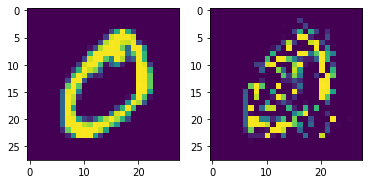

In [17]:
from z3 import Real, Solver, sat

vars = {}
s = Solver()

# Greedy
for constraint_ in constraints:
    prev_constraints = s.assertions()
    for constraint in constraint_:
        feat, sign, thresh = constraint
        if feat not in vars:
            vars[feat] = Real(feat)
        if sign == '>':
            s.add(vars[feat] > thresh)
        else:
            s.add(vars[feat] <= thresh)
        # If we reach an unsolvable constraint, skip it,
        # and recreate the solver with the previous constriaints
        if s.check() != sat:
            s = Solver()
            for prev_constraint in prev_constraints:
                s.add(prev_constraint)
            break
            
s.check()
model = s.model()
adv_sample = sample.copy()
n_pixels_changed = 0

for feat in vars:
    val = model[vars[feat]]
    if val is None:
        continue
    n_pixels_changed += 1
    val = val.as_fraction()
    val = float(val.numerator) / float(val.denominator)
    adv_sample[int(feat[1:])] = val

print(f"Number of pixels changed: {n_pixels_changed}")
print(f"Predicted class: {clf.predict([adv_sample])[0]}")
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(sample.reshape(28, 28))
ax[1].imshow(adv_sample.reshape(28, 28))
plt.show()